# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

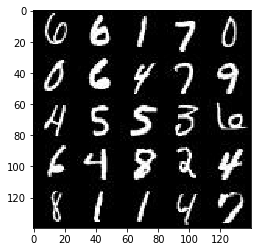

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

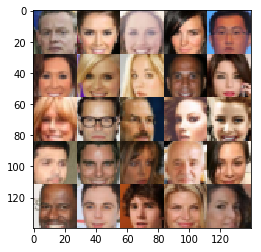

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape = [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
    
        l_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        l_1 = tf.maximum(alpha*l_1, l_1)
        
        l_2 = tf.layers.conv2d(l_1, 128, 5, strides=2, padding='SAME')
        l_2 = tf.layers.batch_normalization(l_2, training=True)
        l_2 = tf.maximum(alpha*l_2, l_2)
        
        l_3 = tf.layers.conv2d(l_2, 256, 5, strides=2, padding='SAME')
        l_3 = tf.layers.batch_normalization(l_3, training=True)
        l_3 = tf.maximum(alpha*l_3, l_3)
        
        flat = tf.reshape(l_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        l_1 = tf.layers.dense(z, 7*7*256)
        l_1 = tf.reshape(l_1, (-1, 7, 7, 256))
        l_1 = tf.layers.batch_normalization(l_1, training=is_train)
        l_1 = tf.maximum(alpha*l_1, l_1)
        
        l_2 = tf.layers.conv2d_transpose(l_1, 128, 5, strides=2, padding='SAME')
        l_2 = tf.layers.batch_normalization(l_2, training=is_train)
        l_2 = tf.maximum(alpha*l_2, l_2)
        
        l_3 = tf.layers.conv2d_transpose(l_2, 64, 5, strides=2, padding='SAME')
        l_3 = tf.layers.batch_normalization(l_3, training=is_train)
        l_3 = tf.maximum(alpha*l_3, l_3)
        
        logits = tf.layers.conv2d_transpose(l_3, out_channel_dim, 5, strides=1, padding='SAME')
        output = tf.tanh(logits)
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # D-loss
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    # G-loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_w, img_h, img_d = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images *= 2 # should be normalized to generator images
                steps += 1

                # Sample input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_d, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4315... Generator Loss: 7.0188
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 14.6454
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.5212
Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 1.9201
Epoch 1/2... Discriminator Loss: 2.5147... Generator Loss: 0.1927
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 1.8070
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 1.3900
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 1.6463... Generator Loss: 0.4707


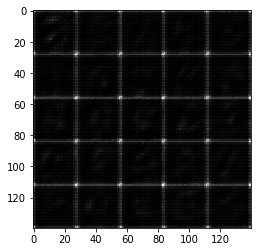

Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 2.0633... Generator Loss: 0.2762
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.8829
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 1.8692... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.7890... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.8475


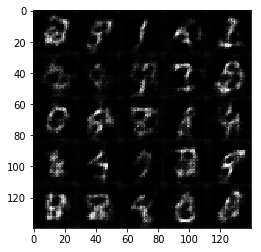

Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 1.0550
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 1.8861
Epoch 1/2... Discriminator Loss: 1.7109... Generator Loss: 0.3947
Epoch 1/2... Discriminator Loss: 1.7813... Generator Loss: 0.3134
Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.6096


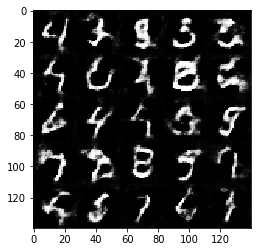

Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.6373... Generator Loss: 0.3890
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.4648
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.6638


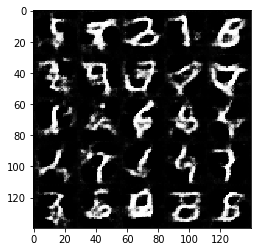

Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 1.1929... Generator Loss: 1.1079
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.4984
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 1.2617


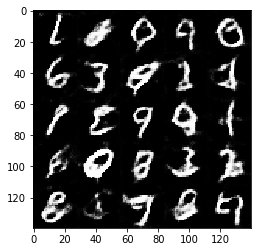

Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 1.1602
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 0.8094


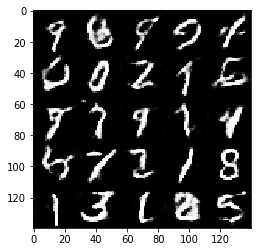

Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 1.3408
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 1.3688
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.9673


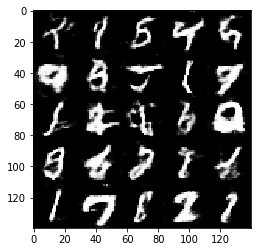

Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.5909
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 1.5454
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 1.4306
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 2.1093
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 0.8301


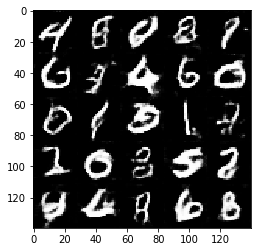

Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 1.3463
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.7653... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.6186


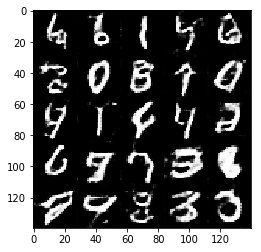

Epoch 1/2... Discriminator Loss: 2.5591... Generator Loss: 0.1781
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.3074
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.6809... Generator Loss: 0.3856


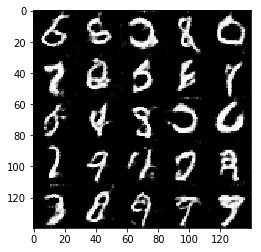

Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 1.9944
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.1789
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.7737
Epoch 1/2... Discriminator Loss: 1.5163... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.5873


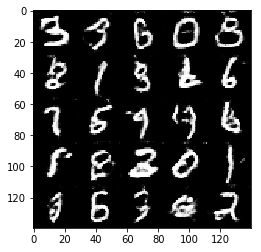

Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.1554
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 1.4860
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.8595


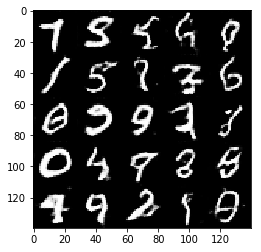

Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 1.1047
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.3934
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.7500
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 1.3088


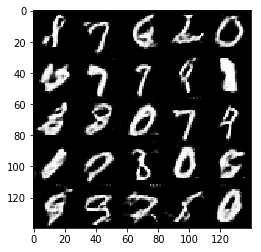

Epoch 1/2... Discriminator Loss: 1.6615... Generator Loss: 0.4076
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.0974
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.7694... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 1.0864
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 1.8280
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 1.0376


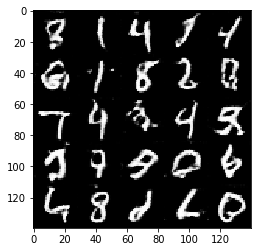

Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.6319
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.7873
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.1384
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.1808
Epoch 1/2... Discriminator Loss: 1.7644... Generator Loss: 0.3436


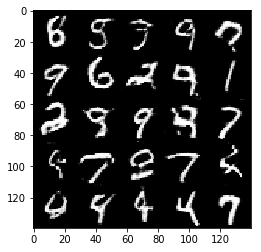

Epoch 1/2... Discriminator Loss: 1.6676... Generator Loss: 0.4617
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.1418
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 1.3203
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.5831
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.5613
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.8357


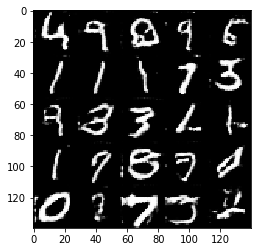

Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.7915
Epoch 1/2... Discriminator Loss: 1.1788... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.4714
Epoch 1/2... Discriminator Loss: 1.7827... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.5076
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.9523


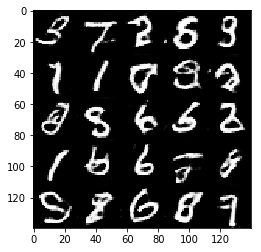

Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.4563
Epoch 1/2... Discriminator Loss: 1.0495... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.8576
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 1.0513


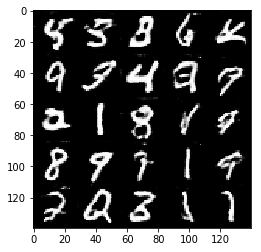

Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 2.1129
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.4545
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.6121
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.5283... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.5371


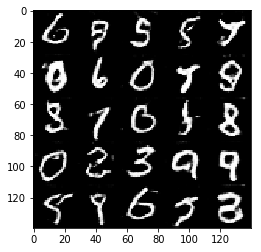

Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.5109... Generator Loss: 0.5213
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.2359
Epoch 2/2... Discriminator Loss: 1.5468... Generator Loss: 0.5104
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 0.6814... Generator Loss: 1.8099


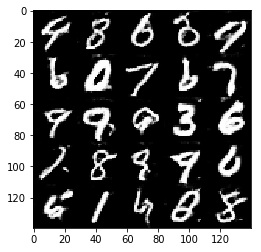

Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.2922
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.8496
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.3164
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 0.9282
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 2.7079
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.4974


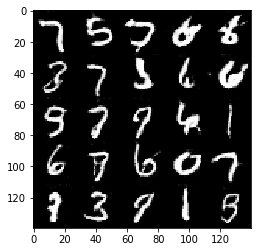

Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 1.8190
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.5572
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.6470... Generator Loss: 0.4730
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.0893
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.6829
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.7917


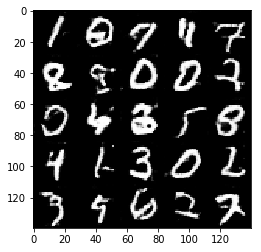

Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.9100
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.4105
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 2.9563
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.0928
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.4436


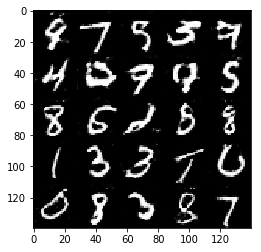

Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.7986
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.7485
Epoch 2/2... Discriminator Loss: 2.6134... Generator Loss: 0.1523
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.7816
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 2.0031
Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.8324
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.7412
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 0.8825


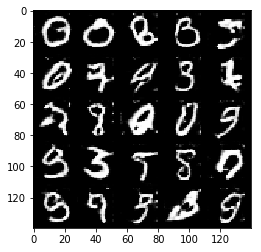

Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.0238
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.7862
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 1.6631... Generator Loss: 0.4232
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.1301
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.4158
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.1929


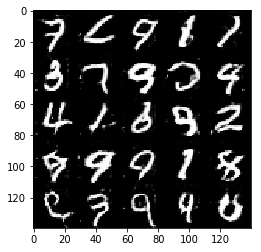

Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 2.2847
Epoch 2/2... Discriminator Loss: 1.6502... Generator Loss: 0.4151
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.2457
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.1902
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.3611
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.1507


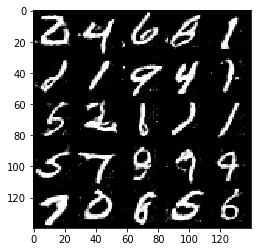

Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 1.5473... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 2.4030... Generator Loss: 0.3227
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.2583
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 3.4846... Generator Loss: 4.8513
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.7119
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.6166


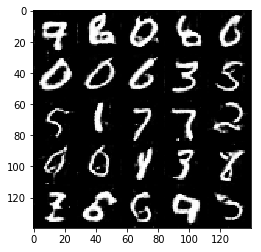

Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.1325
Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.4234
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 1.7176
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.9046
Epoch 2/2... Discriminator Loss: 1.7352... Generator Loss: 0.5475
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.8787
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.8272


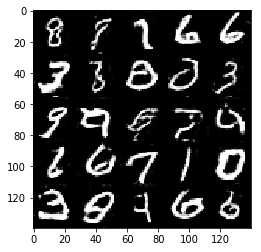

Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.5821
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 0.7412... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 2.0601
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.5158
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 2.4133
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.5761
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.4255


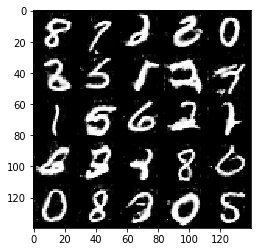

Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.9188
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.1762
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 1.8831
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 1.1451
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.8348
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.7132
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 1.8799... Generator Loss: 0.3370


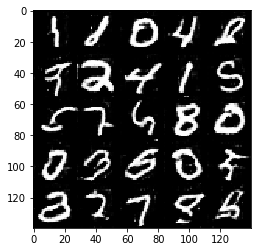

Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 1.2085
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.6715
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 1.5268... Generator Loss: 0.5046
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.4897
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.7222


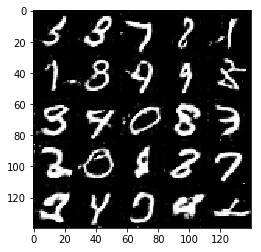

Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.2883
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.2457
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 1.9723
Epoch 2/2... Discriminator Loss: 0.8694... Generator Loss: 2.5556
Epoch 2/2... Discriminator Loss: 1.5344... Generator Loss: 0.4827
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 2.3440


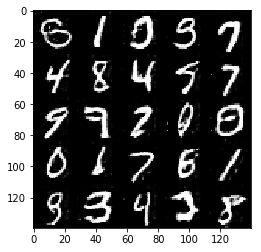

Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 0.6918... Generator Loss: 1.7525
Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 2.5137... Generator Loss: 0.2187
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.1587
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.7520
Epoch 2/2... Discriminator Loss: 1.8593... Generator Loss: 0.3503
Epoch 2/2... Discriminator Loss: 2.7573... Generator Loss: 3.9269
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 2.1412
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.1494


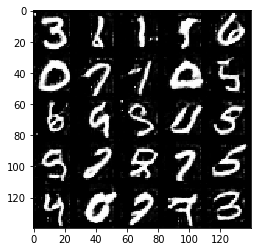

Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.1238
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.6387
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 2.8310
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 0.8737... Generator Loss: 1.1824
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 1.9541... Generator Loss: 0.3409
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.6518
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 0.8759


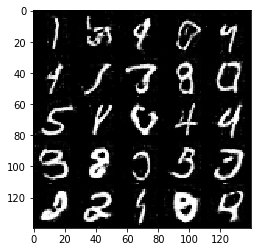

Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 1.6919... Generator Loss: 0.4408
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.8291
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.7657
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 0.8492... Generator Loss: 1.1093
Epoch 2/2... Discriminator Loss: 0.6391... Generator Loss: 2.1330
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.0922
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.3453


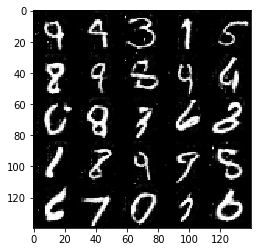

Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.4807
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.6777
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.5564
Epoch 2/2... Discriminator Loss: 1.9866... Generator Loss: 2.9550
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.7784


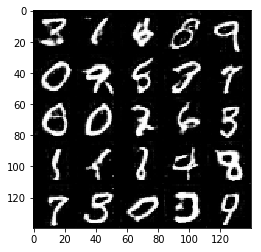

Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.6619
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.6377... Generator Loss: 0.4517
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 0.9895
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 1.8489
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.8883
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 2.0965
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 1.0404


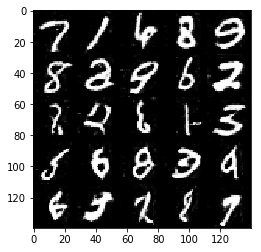

Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.8821
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.7274
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.1042... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.6833


In [28]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 2.2971... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 2.5565... Generator Loss: 0.1612
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 3.1176
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 3.8902
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 4.1355


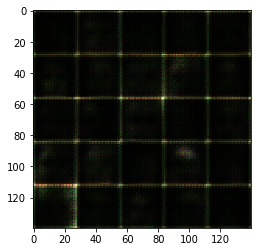

Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 2.0021... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 2.5207
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.7852
Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.9425
Epoch 1/1... Discriminator Loss: 1.8031... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.9898... Generator Loss: 0.3168
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.3642
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8276


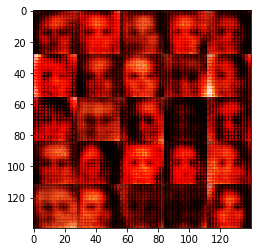

Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 6.6855
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.5655
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 2.3946
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.6521


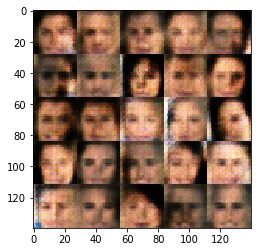

Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.8437... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 2.4738
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 2.5147
Epoch 1/1... Discriminator Loss: 1.7267... Generator Loss: 0.4372


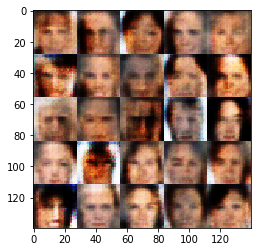

Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.9323
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.7742


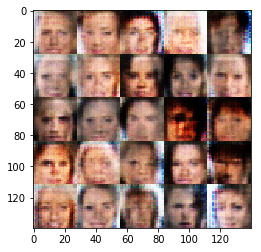

Epoch 1/1... Discriminator Loss: 1.7771... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.7054... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.2304


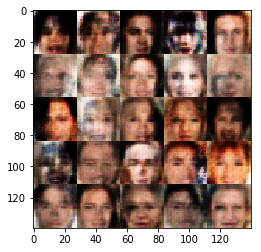

Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 2.4917
Epoch 1/1... Discriminator Loss: 1.7654... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.8789
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6113


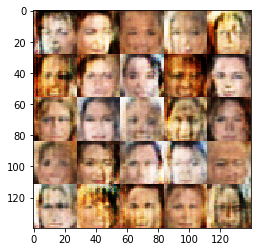

Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 2.1213... Generator Loss: 0.2087


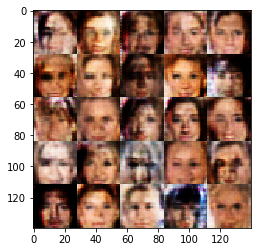

Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 2.5638
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.9386
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 2.2519
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 2.2920
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.2053


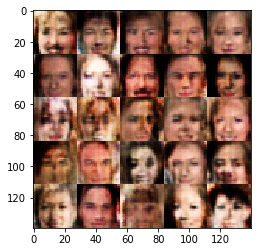

Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 3.8075
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 2.6878
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.8470


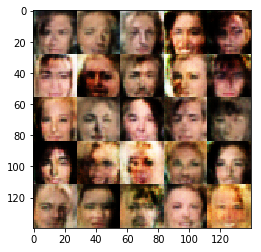

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6183


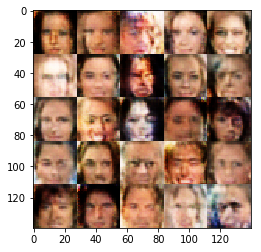

Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 3.5630
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 2.0868
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5614


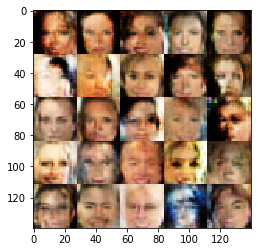

Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 1.6945
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.8568


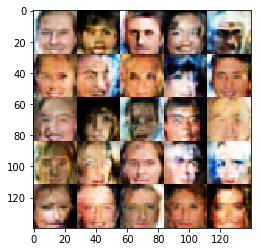

Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.9714


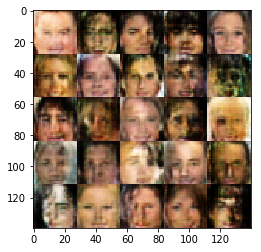

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.2297


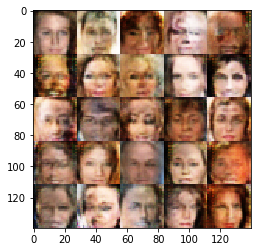

Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 1.7095... Generator Loss: 0.3507


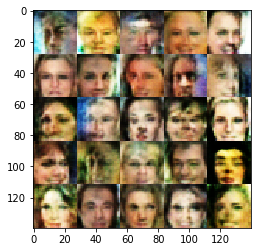

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.4117
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.9936


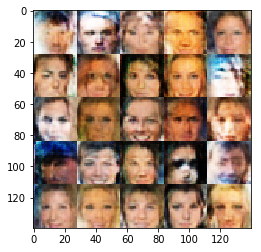

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.9982... Generator Loss: 0.2592
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.4345
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4718


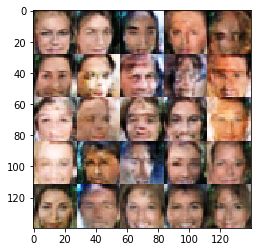

Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.4258
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8162


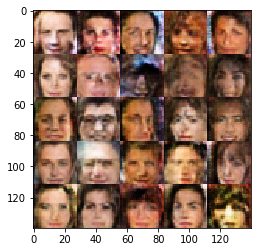

Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8187


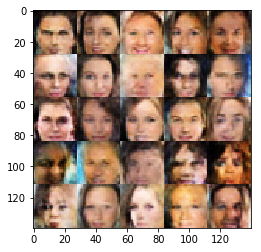

Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.7122... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7977


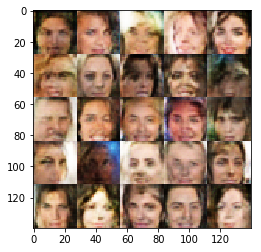

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.5326


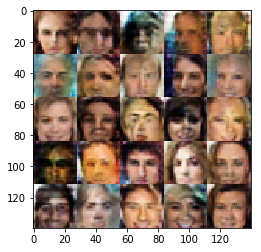

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.3687


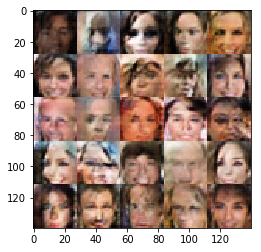

Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 1.5439


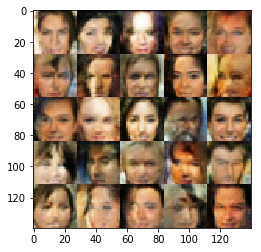

Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.9526... Generator Loss: 0.2797
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.3727


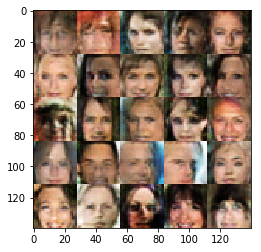

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.9731


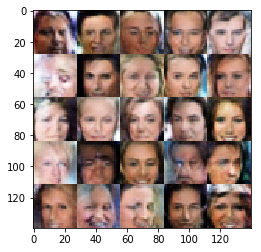

Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6244


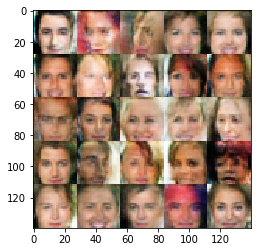

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6964


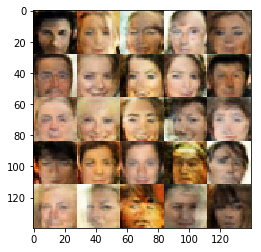

Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.1446


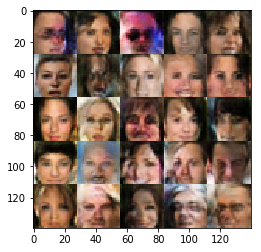

Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.2009


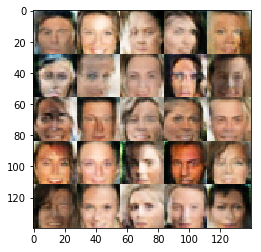

Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.8652


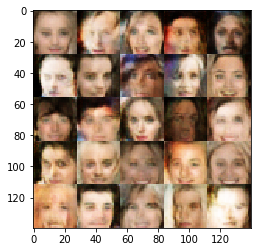

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.0097


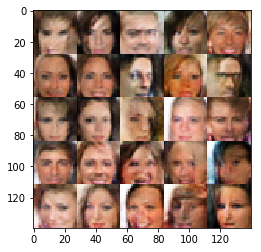

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.3774
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6838


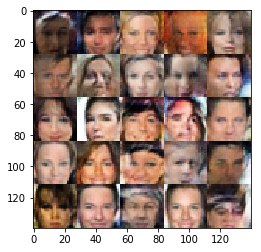

Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6703


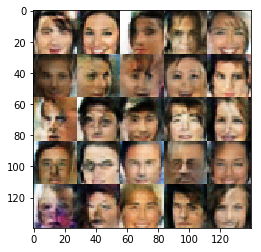

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6679


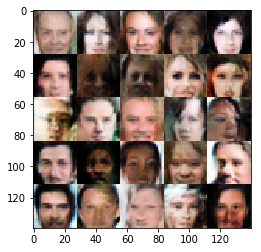

Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.4497
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6036


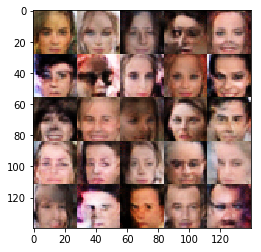

Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.9877


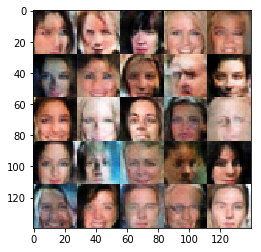

Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6105


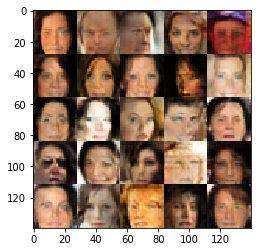

Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9289


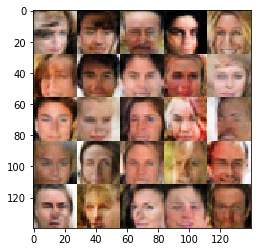

Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8614


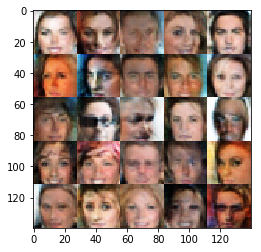

Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7745


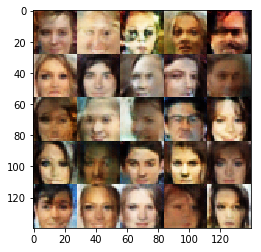

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.3186


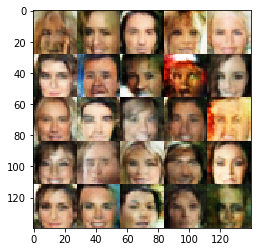

Epoch 1/1... Discriminator Loss: 1.6597... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6050


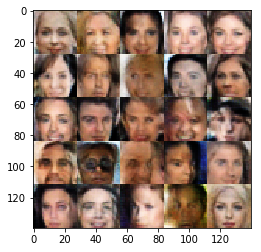

Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 1.1438


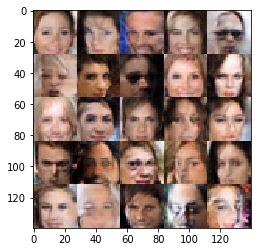

Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7031


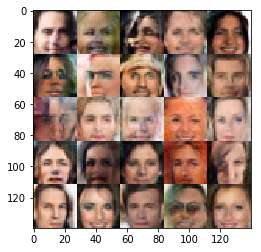

Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6474


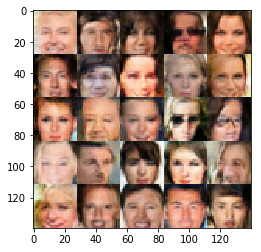

Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.7570


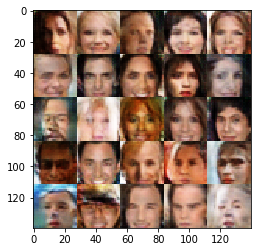

Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8570


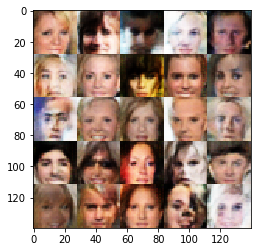

Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.9106


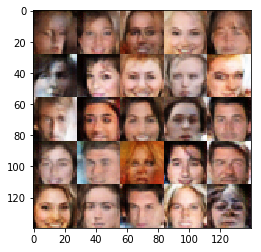

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.3757


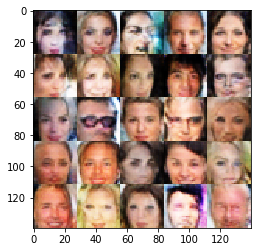

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5736


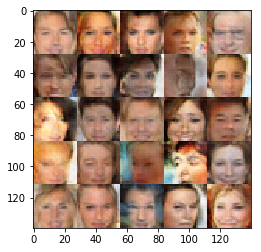

Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.5539


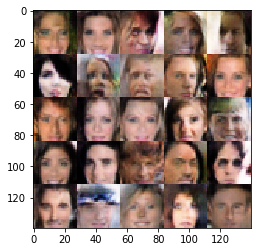

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.1771


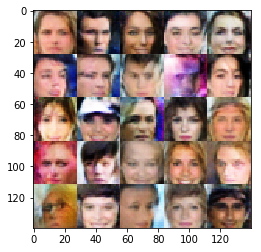

Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5808


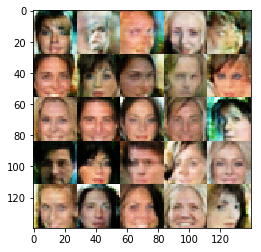

Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6182


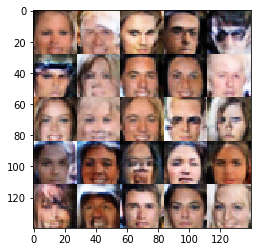

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8276


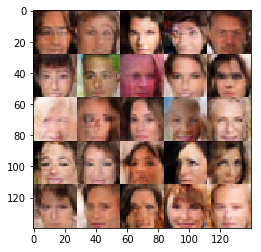

Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5720


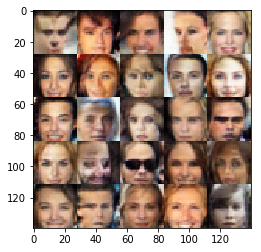

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7775


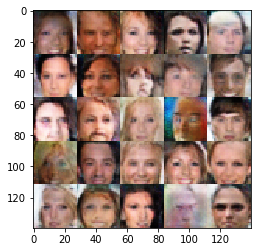

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7797


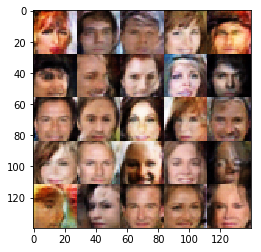

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.6461


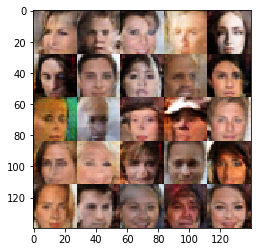

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7714


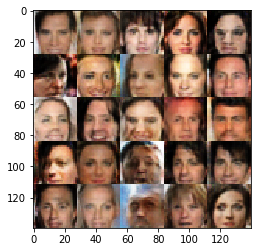

Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.1173


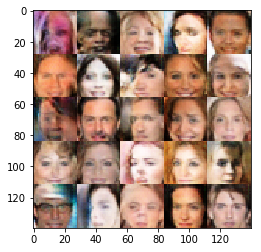

Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7889


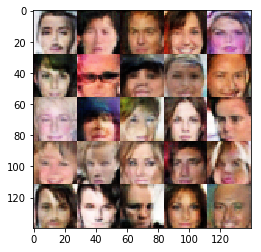

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8554


In [29]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.